In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
import numpy as np
import pickle

import tensorflow as tf
import keras

## If Error, change keras -> tensorflow.keras

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dense, Reshape
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
from tensorflow.keras.utils import plot_model

from cddd.inference import InferenceModel
from cddd.preprocessing import preprocess_smiles
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import QED
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import import_ipynb
import sascorer
import keras


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\TY\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(68, 15)
(527, 15)
(246, 15)
(88, 15)


C:\Users\TY\anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\TY\anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\TY\anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\TY\anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying 

(array([298., 517., 514., 410., 329., 275., 156.,  94.,  51.,   8.]),
 array([4.   , 4.587, 5.174, 5.761, 6.348, 6.935, 7.522, 8.109, 8.696,
        9.283, 9.87 ]),
 <BarContainer object of 10 artists>)

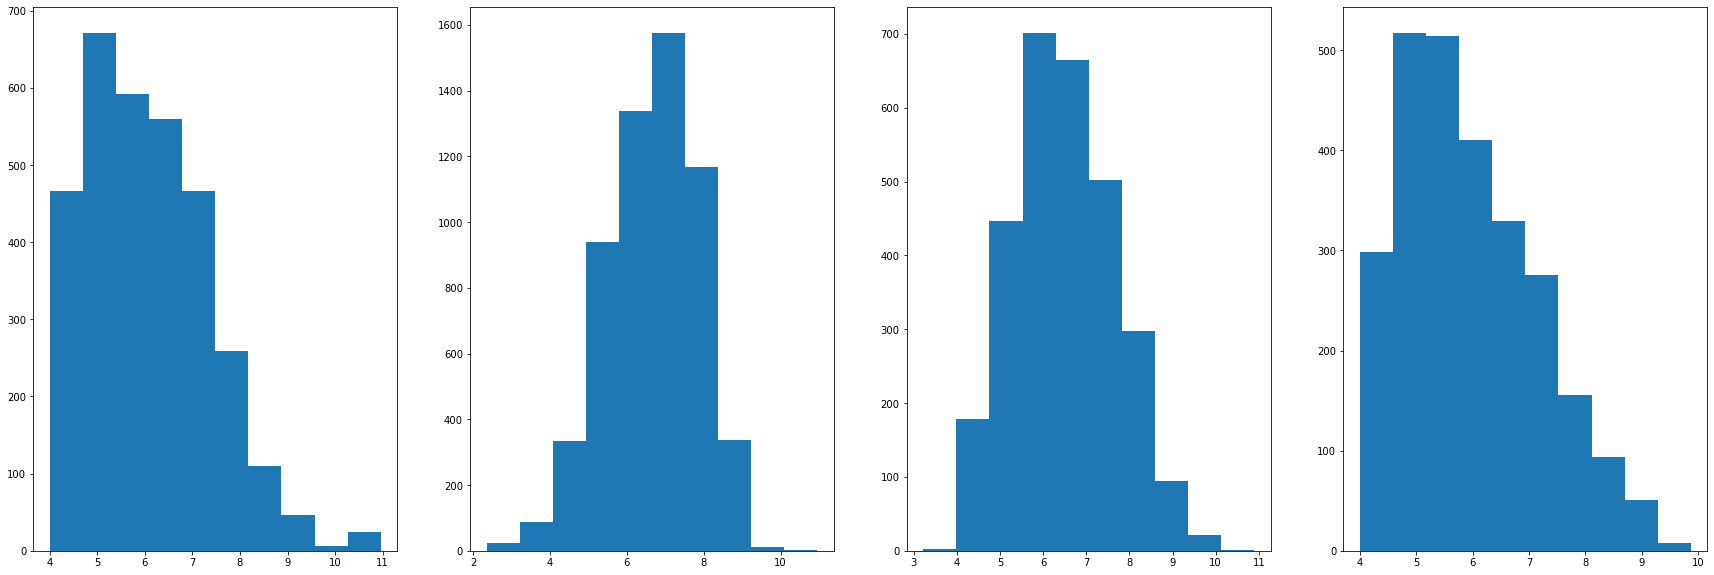

In [4]:
df_activity = pd.read_csv('chembl_activity_whole.tsv', sep = '\t')
df_activity['Molecule Name'] = df_activity['Molecule Name'].apply(lambda x: str(x).lower())

AD_targets = ['Glycogen synthase kinase-3 beta', 'Beta-secretase 1', 'Monoamine oxidase B' , 'Glycogen synthase kinase-3 beta']
#AD_targets = ['Glycogen synthase kinase-3 beta', 'Beta-secretase 1', 'Glycogen synthase kinase-3 beta']
#AD_targets = ['Glycogen synthase kinase-3 beta', 'Glycogen synthase kinase-3 beta'] # == 'GSK3', 'BACE1'
features = ['pChEMBL Value', 'Target Name', 'AlogP', 'Molecule Name', 'Molecule ChEMBL ID', 'Molecule Max Phase', 'Smiles']

df_AD = df_activity[df_activity['Target Name'].isin(AD_targets)]
df_AD = df_AD[features]
df_AD['Smiles_preprocessed'] = df_AD['Smiles'].map(preprocess_smiles)

## GSK3, BACE1, GSK3, MAO

df_pivot = df_AD.pivot_table(values = 'pChEMBL Value', index = 'Smiles_preprocessed', columns = 'Target Name', aggfunc = 'mean')
df_pivot = df_pivot.groupby('Smiles_preprocessed').fillna(0)

target_instance = np.count_nonzero(df_pivot, axis = 0)
smiles_instance = np.count_nonzero(df_pivot, axis = 1)
smiles_instance = smiles_instance.reshape(-1, 1)


df_multi = df_pivot.loc[smiles_instance >= 2]

df_BACE1 = df_pivot[(df_pivot['Beta-secretase 1'] != 0) & (~df_pivot.index.isin(df_multi.index))]
df_GSK3 = df_pivot[(df_pivot['Glycogen synthase kinase-3 beta'] != 0) & (~df_pivot.index.isin(df_multi.index))]
df_GSK3 = df_pivot[(df_pivot['Glycogen synthase kinase-3 beta'] != 0) & (~df_pivot.index.isin(df_multi.index))]
df_MAO = df_pivot[(df_pivot['Monoamine oxidase B'] != 0) & (~df_pivot.index.isin(df_multi.index))]


df_BACE1 = Chem_scores(df_BACE1)
df_GSK3 = Chem_scores(df_GSK3)
df_GSK3 = Chem_scores(df_GSK3)
df_MAO = Chem_scores(df_MAO)

df_A = df_GSK3[(df_GSK3['MW'] < 500) & (df_GSK3['MW'] > 300) &
        (df_GSK3['Glycogen synthase kinase-3 beta'] >= 8) &
        (df_GSK3['Glycogen synthase kinase-3 beta'] <= 9) &
        (df_GSK3['ALOGP'] < 5)]
print(df_A.shape)

df_B = df_BACE1[(df_BACE1['MW'] < 500) & (df_BACE1['MW'] > 300) &
         (df_BACE1['Beta-secretase 1'] >= 8) &
         (df_BACE1['Beta-secretase 1'] <= 9) &
         (df_BACE1['ALOGP'] < 5)]
print(df_B.shape)

df_G = df_GSK3[(df_GSK3['MW'] < 500) & (df_GSK3['MW'] > 300) &
        (df_GSK3['Glycogen synthase kinase-3 beta'] >= 8) &
        (df_GSK3['Glycogen synthase kinase-3 beta'] <= 9) &
        (df_GSK3['ALOGP'] < 5)]
print(df_G.shape)

df_M = df_MAO[(df_MAO['MW'] < 500) & (df_MAO['MW'] > 300) &
        (df_MAO['Monoamine oxidase B'] >= 8) &
        (df_MAO['Monoamine oxidase B'] <= 9) &
        (df_MAO['ALOGP'] < 5)]
print(df_M.shape)

df_input = pd.concat([df_A, df_B, df_G, df_M])
df_input = df_input.reset_index()

df_input['Target'] = ""
for i,r in df_input.iterrows():
    if r['Glycogen synthase kinase-3 beta'] > 0:
        df_input['Target'][i] = 'GSK3'
    elif r['Beta-secretase 1'] > 0:
        df_input['Target'][i] = 'BACE1'
    elif r['Glycogen synthase kinase-3 beta'] > 0:
        df_input['Target'][i] = 'GSK3'
    elif r['Monoamine oxidase B'] > 0:
        df_input['Target'][i] = 'MAO'
    else:
        df_input['Target'][i] = 'Unknown'
        
######
fig, axes = plt.subplots(figsize = (30, 10), ncols = 4)
axes[0].hist(df_GSK3['Glycogen synthase kinase-3 beta'])
axes[1].hist(df_BACE1['Beta-secretase 1'])
axes[2].hist(df_GSK3['Glycogen synthase kinase-3 beta'])
axes[3].hist(df_MAO['Monoamine oxidase B'])

In [2]:
def Chem_scores(df):
    df = df.reset_index()
    df['mols'] = df[df.columns[0]].apply(lambda x: Chem.MolFromSmiles(x))
    #df['mols'].apply(lambda x: Chem.AddHs(x)) # This will be added in Chimera
    #df['mols'].apply(lambda x: AllChem.EmbedMolecule(x))
    #df['mols'].apply(lambda x: AllChem.ComputeGasteigerCharges(x))
    df['QED_score'] = df['mols'].apply(lambda x: QED.qed(x))
    df['SA_score'] = df['mols'].apply(lambda x: sascorer.calculateScore(x))
    df['MW'] = df['mols'].apply(lambda x: QED.properties(x)[0])
    df['ALOGP'] = df['mols'].apply(lambda x: QED.properties(x)[1])
    df['HBA'] = df['mols'].apply(lambda x: QED.properties(x)[2])
    df['HBD'] = df['mols'].apply(lambda x: QED.properties(x)[3])
    df['PSA'] = df['mols'].apply(lambda x: QED.properties(x)[4])
    df['ROTB'] = df['mols'].apply(lambda x: QED.properties(x)[5])
    df['AROM'] = df['mols'].apply(lambda x: QED.properties(x)[6])
    df['ALERTS'] = df['mols'].apply(lambda x: QED.properties(x)[7])
    df = df.set_index(df.columns[0])
    return df

In [3]:
df_activity = pd.read_csv('chembl_activity_whole.tsv', sep = '\t')
df_activity['Molecule Name'] = df_activity['Molecule Name'].apply(lambda x: str(x).lower())

AD_targets = ['Glycogen synthase kinase-3 beta', 'Beta-secretase 1'] # == 'GSK3', 'BACE1'
features = ['pChEMBL Value', 'Target Name', 'AlogP', 'Molecule Name', 'Molecule ChEMBL ID', 'Molecule Max Phase', 'Smiles']

df_AD = df_activity[df_activity['Target Name'].isin(AD_targets)]
df_AD = df_AD[features]
df_AD['Smiles_preprocessed'] = df_AD['Smiles'].map(preprocess_smiles)

/Users/ty/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocess

In [4]:
## GSK3, BACE1

df_pivot = df_AD.pivot_table(values = 'pChEMBL Value', index = 'Smiles_preprocessed', columns = 'Target Name', aggfunc = 'mean')
df_pivot = df_pivot.groupby('Smiles_preprocessed').fillna(0)

target_instance = np.count_nonzero(df_pivot, axis = 0)
smiles_instance = np.count_nonzero(df_pivot, axis = 1)
smiles_instance = smiles_instance.reshape(-1, 1)


df_multi = df_pivot.loc[smiles_instance == 2]

df_GSK3 = df_pivot[(df_pivot['Glycogen synthase kinase-3 beta'] != 0) & (~df_pivot.index.isin(df_multi.index))]
df_BACE1 = df_pivot[(df_pivot['Beta-secretase 1'] != 0) & (~df_pivot.index.isin(df_multi.index))]

In [5]:
df_GSK3 = df_pivot[(df_pivot['Glycogen synthase kinase-3 beta'] != 0) & (~df_pivot.index.isin(df_multi.index))]
df_BACE1 = df_pivot[(df_pivot['Beta-secretase 1'] != 0) & (~df_pivot.index.isin(df_multi.index))]

In [6]:
df_GSK3 = Chem_scores(df_GSK3)
df_BACE1 = Chem_scores(df_BACE1)

In [7]:
df_GSK3 = df_GSK3[(df_GSK3['MW'] < 500) & (df_GSK3['MW'] > 300) &
        (df_GSK3['Glycogen synthase kinase-3 beta'] >= 8) &
        (df_GSK3['Glycogen synthase kinase-3 beta'] <= 9) &
        (df_GSK3['ALOGP'] < 5)]
print(df_GSK3.shape)

df_BACE1 = df_BACE1[(df_BACE1['MW'] < 500) & (df_BACE1['MW'] > 300) &
        (df_BACE1['Beta-secretase 1'] >= 8) &
        (df_BACE1['Beta-secretase 1'] <= 9) &
        (df_BACE1['ALOGP'] < 5)]
print(df_BACE1.shape)

df_GSK3['ECFP'] = df_GSK3['mols'].apply(lambda x: AllChem.GetMorganFingerprint(x, radius = 2))
df_BACE1['ECFP'] = df_BACE1['mols'].apply(lambda x: AllChem.GetMorganFingerprint(x, radius = 2))

(246, 13)
(527, 13)


In [9]:
keras.backend.clear_session()
inference_model = InferenceModel()

BACE1_smiles = df_BACE1.index.to_list()
GSK3_smiles = df_GSK3.index.to_list()
X1 = inference_model.seq_to_emb(BACE1_smiles)
X2 = inference_model.seq_to_emb(GSK3_smiles)






Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.



Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Restoring parameters from /Users/

In [9]:
X1_smiles = inference_model.emb_to_seq(X1)
X2_smiles = inference_model.emb_to_seq(X2)

INFO:tensorflow:Restoring parameters from C:\Users\TY\anaconda3\lib\site-packages\cddd\data\default_model\model.ckpt
INFO:tensorflow:Restoring parameters from C:\Users\TY\anaconda3\lib\site-packages\cddd\data\default_model\model.ckpt


In [10]:
print(len(BACE1_smiles), len(set(BACE1_smiles) & set(X1_smiles)))

527 487


In [11]:
print(len(BACE1_smiles), len(set(BACE1_smiles) & set(X1_smiles)))
print(len(GSK3_smiles), len(set(GSK3_smiles) & set(X2_smiles)))

527 487
246 242


In [10]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# define layer
layer = InstanceNormalization(axis=-1)

In [11]:
def define_discriminator(input_shape):
    # weight initialisation
    init = RandomNormal(stddev = 0.02)
    # input
    in_struc = Input(shape = input_shape)
    
    d = Dense(384, kernel_initializer = init)(in_struc)
    d = InstanceNormalization()(d)
    d = LeakyReLU(alpha = 0.2)(d)
    
    d = Dense(256, kernel_initializer = init)(d)
    d = InstanceNormalization()(d)
    d = LeakyReLU(alpha = 0.2)(d)
    
    d = Dense(128, kernel_initializer = init)(d)
    d = InstanceNormalization()(d)
    d = LeakyReLU(alpha = 0.2)(d)
    
    d = Dense(64, kernel_initializer = init)(d)
    d = InstanceNormalization()(d)
    d = LeakyReLU(alpha = 0.2)(d)
    
    d = Dense(32, kernel_initializer = init)(d)
    d = InstanceNormalization()(d)
    d = LeakyReLU(alpha = 0.2)(d)
    
    out = Dense(units = 1, activation = 'sigmoid')(d)
    model = Model(in_struc, out)
    model.compile(loss = 'mse', optimizer = Adam(lr = 0.000001, beta_1 = 0.5), loss_weights = [0.5])
    return model

In [12]:
def resnet_block(n_neuron, input_layer):
    init = RandomNormal(stddev=0.02)
    g = Dense(n_neuron, kernel_initializer = init)(input_layer)
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
    g = Concatenate()([g, input_layer])
    return g

In [13]:
def define_generator(input_shape, n_resnet = 5):
    init = RandomNormal(stddev = 0.2)
    in_latent = Input(shape = input_shape)
    g = Dense(256, kernel_initializer = init)(in_latent) # or unit = 512
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
    for _ in range(n_resnet):
        g = resnet_block(512, g)
        
    g = Dense(1536, kernel_initializer = init)(g)
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
        
    g = Dense(768, kernel_initializer = init)(g)
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
    
    out = Dense(units = 512, activation = None)(g)
    model = Model(in_latent, out)
    return model

In [14]:
def define_composite_model(g_model_1, d_model, g_model_2, latent_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    input_gen = Input(shape=latent_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    input_id = Input(shape=latent_shape)
    output_id = g_model_1(input_id)
    output_f = g_model_2(gen1_out)
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    opt = Adam(lr=0.000001, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

In [15]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

In [16]:
def generate_fake_samples(g_model, dataset):
    X = g_model.predict(dataset)
    y = zeros((len(X), 1))
    return X, y

In [17]:
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'generated_molecules/GBmodel/AtoB/g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    filename2 = 'generated_molecules/GBmodel/BtoA/g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [18]:
def summarize_performance(step, g_model_1, trainX, mols_r, name,
                          rec, rec_unique, df_topsim, # -> empty pandas df
                          df_GSK3 = df_GSK3, df_BACE1 = df_BACE1):
    
    X_in = trainX
    X_out, _ = generate_fake_samples(g_model_1, X_in)
    #X_rc, _ = generate_fake_samples(g_model_2, X_out)
    
    smiles_g = inference_model.emb_to_seq(X_out)
    #smiles_rc = inference_model.emb_to_seq(X_rc)
    
    mols_g = [Chem.MolFromSmiles(x) for x in smiles_g]
    #mols_rc = [Chem.MolFromSmiles(x) for x in smiles_rc]
    
    # mols_r should be mols from original datasets
    # i.e. mols_A = GSK3 inhibitors, mols_B = BACE1 inhibitors
    df_GEN = pd.DataFrame({
        'smiles_g':smiles_g, 'mols_r':mols_r, 'mols_g':mols_g, #'mols_rc':mols_rc
    })
    df_GEN.dropna(inplace = True)
    
    rec.append(df_GEN.shape[0])
    rec_unique.append(len(df_GEN['smiles_g'].unique()))
    
    
    ## copy and paste from GSK3_BACE1_eval
    df_GEN['A_Best'] = ""
    df_GEN['A_score'] = ""
    df_GEN['B_Best'] = ""
    df_GEN['B_score'] = ""
    
    df_GEN['ECFP_g'] = df_GEN['mols_g'].apply(lambda x: AllChem.GetMorganFingerprint(x, radius = 2))
    
    df_GEN['validation_split'] = step
    df_GEN['generator'] = name
    
    for i,r in df_GEN.iterrows():
        # calculate tanimoto sim across all molecules in Domain A
        A_tanimoto = np.array([DataStructs.TanimotoSimilarity(r['ECFP_g'], x) for x in df_GSK3['ECFP']])
        A_ind = A_tanimoto.argsort()[-1] # Highest value
        
        B_tanimoto = np.array([DataStructs.TanimotoSimilarity(r['ECFP_g'], x) for x in df_BACE1['ECFP']])
        B_ind = B_tanimoto.argsort()[-1]
        
        df_GEN['A_score'][i] = A_tanimoto[A_ind]
        df_GEN['A_Best'][i] = df_GSK3.index[A_ind]
        df_GEN['B_score'][i] = B_tanimoto[B_ind]
        df_GEN['B_Best'][i] = df_BACE1.index[B_ind]
#    df_topsim = pd.concat([df_topsim, df_GEN[(df_GEN['A_score'] > 0.4) & (df_GEN['B_score'] > 0.4)]],
#                          ignore_index = True)

    df_topsim = pd.concat([df_topsim, df_GEN], ignore_index = True)
    #df_topsim = df_topsim.drop_duplicates(['smiles_g']).reset_index(drop = True)
    print('topsim molecules are: ', df_topsim.shape)

    
    
    df_GEN['QED_score'] = df_GEN['mols_g'].apply(lambda x: QED.qed(x))
    df_GEN['SA_score'] = df_GEN['mols_g'].apply(lambda x: sascorer.calculateScore(x))
    
    return df_topsim

In [19]:
def training():
    df_topsim = pd.DataFrame()
    for i in range(5):
        df_topsim = performance(df_topsim)
    return df_topsim

def performance(df_topsim):
    df_gen = pd.DataFrame({'smiles':[1,2,3], 'gen':[4,5,6], 'validation_split':[7,8,9]})
    df_topsim = pd.concat([df_topsim, df_gen], ignore_index = True)
    return df_topsim

df_topsim = training()

In [20]:
def update_molecule(pool, molecules, max_size=20):
    selected = list()
    for molecule in molecules:
        if len(pool) < max_size:
            pool.append(molecule)
            selected.append(molecule)
        elif random() < 0.5:
            selected.append(molecule)
        else:
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = molecule
    return asarray(selected)

In [21]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    
    recovery = []
    recovery_unique = []
    df_topsim = pd.DataFrame()
    
    n_epochs, n_batch, = 500, 1
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    record = {}

    for i in range(n_steps):
        X_realA, y_realA = generate_real_samples(trainA, n_batch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch)
        
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA)

        X_fakeA = update_molecule(poolA, X_fakeA)
        X_fakeB = update_molecule(poolB, X_fakeB)

        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % 
              (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        record[i+1] = dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            df_topsim = \
            summarize_performance(i, g_model_AtoB, trainA, df_GSK3['mols'], 'AtoB', recovery, recovery_unique, df_topsim)
            # plot B->A translation
            df_topsim = \
            summarize_performance(i, g_model_BtoA, trainB, df_BACE1['mols'], 'BtoA', recovery, recovery_unique, df_topsim)
        if (i+1) % (bat_per_epo * 1) == 0:
            # save the models
            save_models(i, g_model_AtoB, g_model_BtoA)
    return record, recovery, recovery_unique, df_topsim

In [22]:
dataset = (X2, X1)
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (246, 512) (527, 512)


In [23]:
#tf.keras.backend.clear_session()

input_shape = (512,)
g_model_AtoB = define_generator(input_shape)
g_model_BtoA = define_generator(input_shape)
d_model_A = define_discriminator(input_shape)
d_model_B = define_discriminator(input_shape)
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, input_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, input_shape)

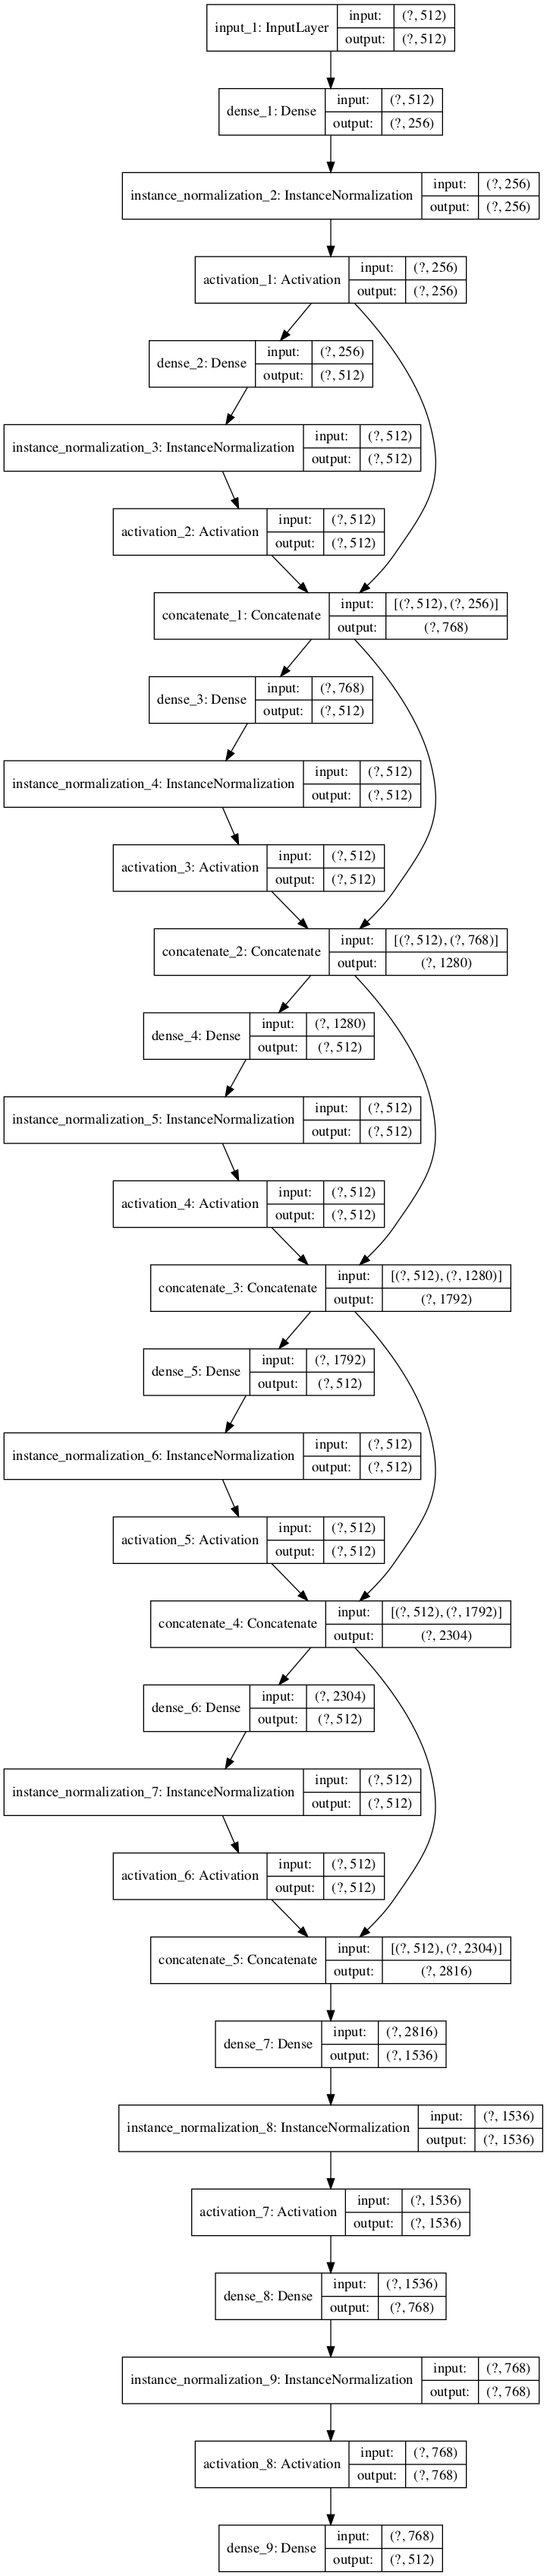

In [24]:
plot_model(g_model_AtoB, show_shapes = True)

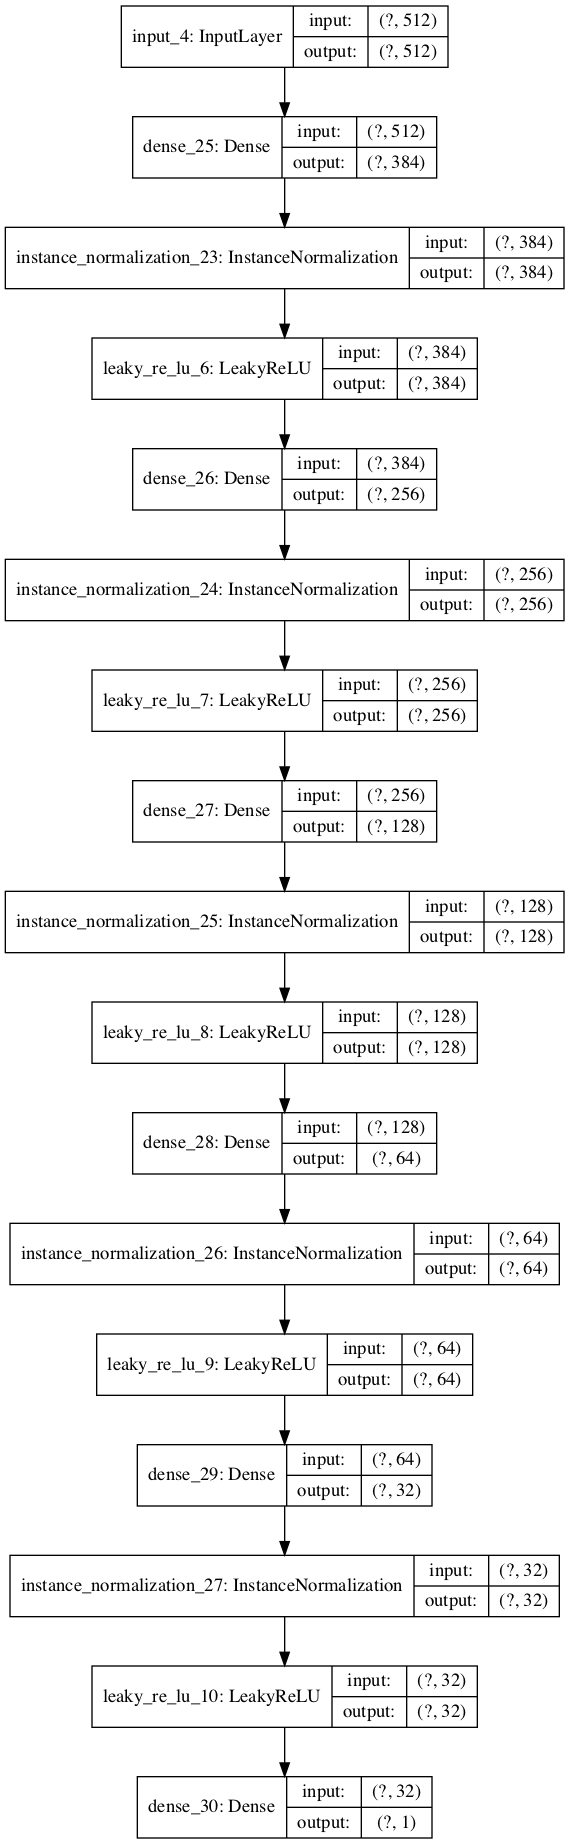

In [25]:
plot_model(d_model_B, show_shapes = True)

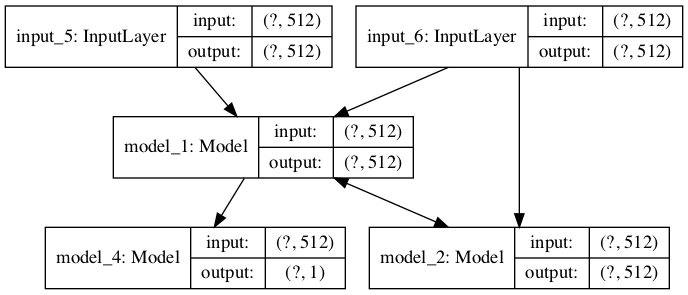

In [26]:
plot_model(c_model_AtoB, show_shapes = True)

In [ ]:
# train models
record, recovery, recovery_unique, df_topsim = train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

In [26]:
df_topsim

,smiles_g,mols_r,mols_g,A_Best,A_score,B_Best,B_score,ECFP_g,epoch,generator
0,[CH]C(O)(CC1CCCC1)c1ccccc1O[O],<rdkit.Chem.rdchem.Mol object at 0x000002734B6...,<rdkit.Chem.rdchem.Mol object at 0x00000274113...,O=C(Nc1n[nH]c2ncc(-c3ccccc3)cc12)C1CCCC1,0.26087,COC1CCC2(CC1)Cc1ccc(OCC3CCCC3)cc1C21N=C(N)N(C)...,0.218182,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,245,AtoB
1,CCC(=[N+]1CCCCC1)c1cc(Cl)ccc1OCC,<rdkit.Chem.rdchem.Mol object at 0x00000273305...,<rdkit.Chem.rdchem.Mol object at 0x00000274113...,CCOc1ccncc1NC(=O)c1ccnc2[nH]c(-c3cccc(OC)c3)nc12,0.179487,CC1(c2cc(NC(=O)c3ccc(Cl)cn3)ccc2F)CS(=O)(=O)C2...,0.201681,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,245,AtoB
2,CCCC1(OCC(C)=[O+]C)CCc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x0000027324E...,<rdkit.Chem.rdchem.Mol object at 0x0000027409F...,CCCC(=O)Nc1n[nH]c2c(F)c(Cl)c(-c3ccccc3)cc12,0.183673,CN1C(=O)C2(NC1N)c1cc(OCC3CC3)ccc1OC21CCc2ccccc...,0.206897,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,245,AtoB
3,CCCC(C)([N+](=O)[O-])c1ccccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x0000027324E...,<rdkit.Chem.rdchem.Mol object at 0x00000274113...,CCCC(=O)Nc1n[nH]c2c(F)c(Cl)c(-c3ccccc3)cc12,0.235294,CN1C(=N)NC(C)(c2sc(-c3ccc(-c4ccccc4)[nH]3)cc2C...,0.18,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,245,AtoB
4,CCCC1(O)c2ccccc2OC1=[O+]CCCC,<rdkit.Chem.rdchem.Mol object at 0x0000027324E...,<rdkit.Chem.rdchem.Mol object at 0x00000274113...,CCCC(=O)Nc1n[nH]c2c(F)c(Cl)c(-c3ccccc3)cc12,0.183673,CC(=O)NC(Cc1ccccc1)C(O)CNC1CC2(CCC2)Oc2ncc(CC(...,0.170732,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,245,AtoB
...,...,...,...,...,...,...,...,...,...,...
380181,COC(=O)c1ccccc1NC(=O)c1ccnc(-c2ccc(NCCO)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x000002734A8...,<rdkit.Chem.rdchem.Mol object at 0x000002775E3...,O=C(O)c1ccccc1Nc1ccnc(Nc2ccc([N+](=O)[O-])cc2)n1,0.401786,COc1ccc2c(c1)C1(N=C(N)N(C)C1=O)c1cc(NC(=O)c3cc...,0.257143,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,122999,BtoA
380182,O=c1cccc(Nc2ccccc2-c2cnn3ncccc23)n1C,<rdkit.Chem.rdchem.Mol object at 0x000002734A8...,<rdkit.Chem.rdchem.Mol object at 0x000002775E3...,COc1cccc(Nc2nccc(-c3cnn4ncccc34)n2)c1,0.453608,CN1C(=O)C2(N=C1N)c1cc(-c3cccnc3)ccc1CC21CCc2cc...,0.293651,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,122999,BtoA
380183,CN(C)c1ccccc1NC(=O)C1=NNC(c2ccc3ncsc3c2)CC1,<rdkit.Chem.rdchem.Mol object at 0x000002734A8...,<rdkit.Chem.rdchem.Mol object at 0x000002775E3...,Nc1ncc(-c2ccccc2)nc1C(=O)Nc1ccccc1N1CCC(N)CC1,0.306452,NC1=NC2(c3cccc(NC(=O)c4ccc(Cl)cn4)c3)CC2CCS1,0.271186,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,122999,BtoA
380184,CN(C(=O)Nc1cccc(Cl)c1)C1=NNC(c2ccc3ncccc3c2)CC1,<rdkit.Chem.rdchem.Mol object at 0x000002734A8...,<rdkit.Chem.rdchem.Mol object at 0x000002775E3...,COc1cccc(C2=NNC(=O)C2=NNc2cccc(Cl)c2)c1,0.336364,NC1=NC2(c3cccc(NC(=O)c4ccc(Cl)cn4)c3)CC2CCS1,0.318966,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,122999,BtoA


In [27]:
len(df_topsim['smiles_g'].unique())

136041

In [28]:
len(df_topsim[(df_topsim['A_score'] > 0.4) & (df_topsim['B_score'] > 0.4)]['smiles_g'].unique())

7

In [29]:
df_topsim.drop(columns = ['mols_r', 'mols_g', 'ECFP_g'], inplace = True)

In [30]:
#df_topsim.to_csv('generated_molecules/topsim_pool_500.csv')

### Loading and Visualising the result

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_topsim = pd.read_csv('generated_molecules/topsim_pool_500.csv', index_col = 0)

In [3]:
## Some smiles_g values are NaN
print(df_topsim.isnull().sum())
## Some smiles_g are not meangingful
display(df_topsim[(df_topsim['A_score'] == 0) | (df_topsim['B_score'] == 0)])

smiles_g     38
A_Best        0
A_score       0
B_Best        0
B_score       0
epoch         0
generator     0
dtype: int64


,smiles_g,A_Best,A_score,B_Best,B_score,epoch,generator
55,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA
57,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA
59,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA
61,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA
62,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA
64,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA
67,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA
68,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA
69,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA
70,NaN,c1ccc(Nc2nccc(-c3c(-c4ccccc4)nn4ncccc34)n2)cc1,0.0,[C-]#[N+]c1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)O2)C2...,0.0,245,BtoA


In [4]:
# Get rid of not useable values, including nan values
print(df_topsim.shape)
df_topsim = df_topsim[(df_topsim['A_score'] != 0) | df_topsim['B_score'] != 0]
df_topsim = df_topsim.reset_index(drop = True)
print(df_topsim.shape)

(380186, 7)
(380147, 7)


In [5]:
mapping = {}
for i, epoch in enumerate(np.unique(df_topsim['epoch'])):
    mapping[epoch] = i+1
df_topsim['validation_split'] = df_topsim['epoch'].map(mapping)
#df_topsim

In [6]:
len(df_topsim['smiles_g'].unique())

136039

In [7]:
df_filter = df_topsim.drop_duplicates(subset = 'smiles_g', keep = 'first')
df_filter.shape

(136039, 8)

In [8]:
no_comp = {}
epoch = []
unique = []
for i in df_filter['validation_split'].unique():
    no_comp[i] = df_filter[df_filter['validation_split'] == i].shape[0]
    epoch.append(i)
    unique.append(df_filter[df_filter['validation_split'] == i].shape[0])

recovery = []
for i in df_topsim['validation_split'].unique():
    recovery.append(df_topsim[df_topsim['validation_split'] == i].shape[0])
    
recovery = np.array(recovery)/(246+527)
recovery = recovery*100 # percentage scale

/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_23232/2909073193.py:59: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = epoch, y = unique,
/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_23232/2909073193.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = epoch[:50], y = recovery[:50],


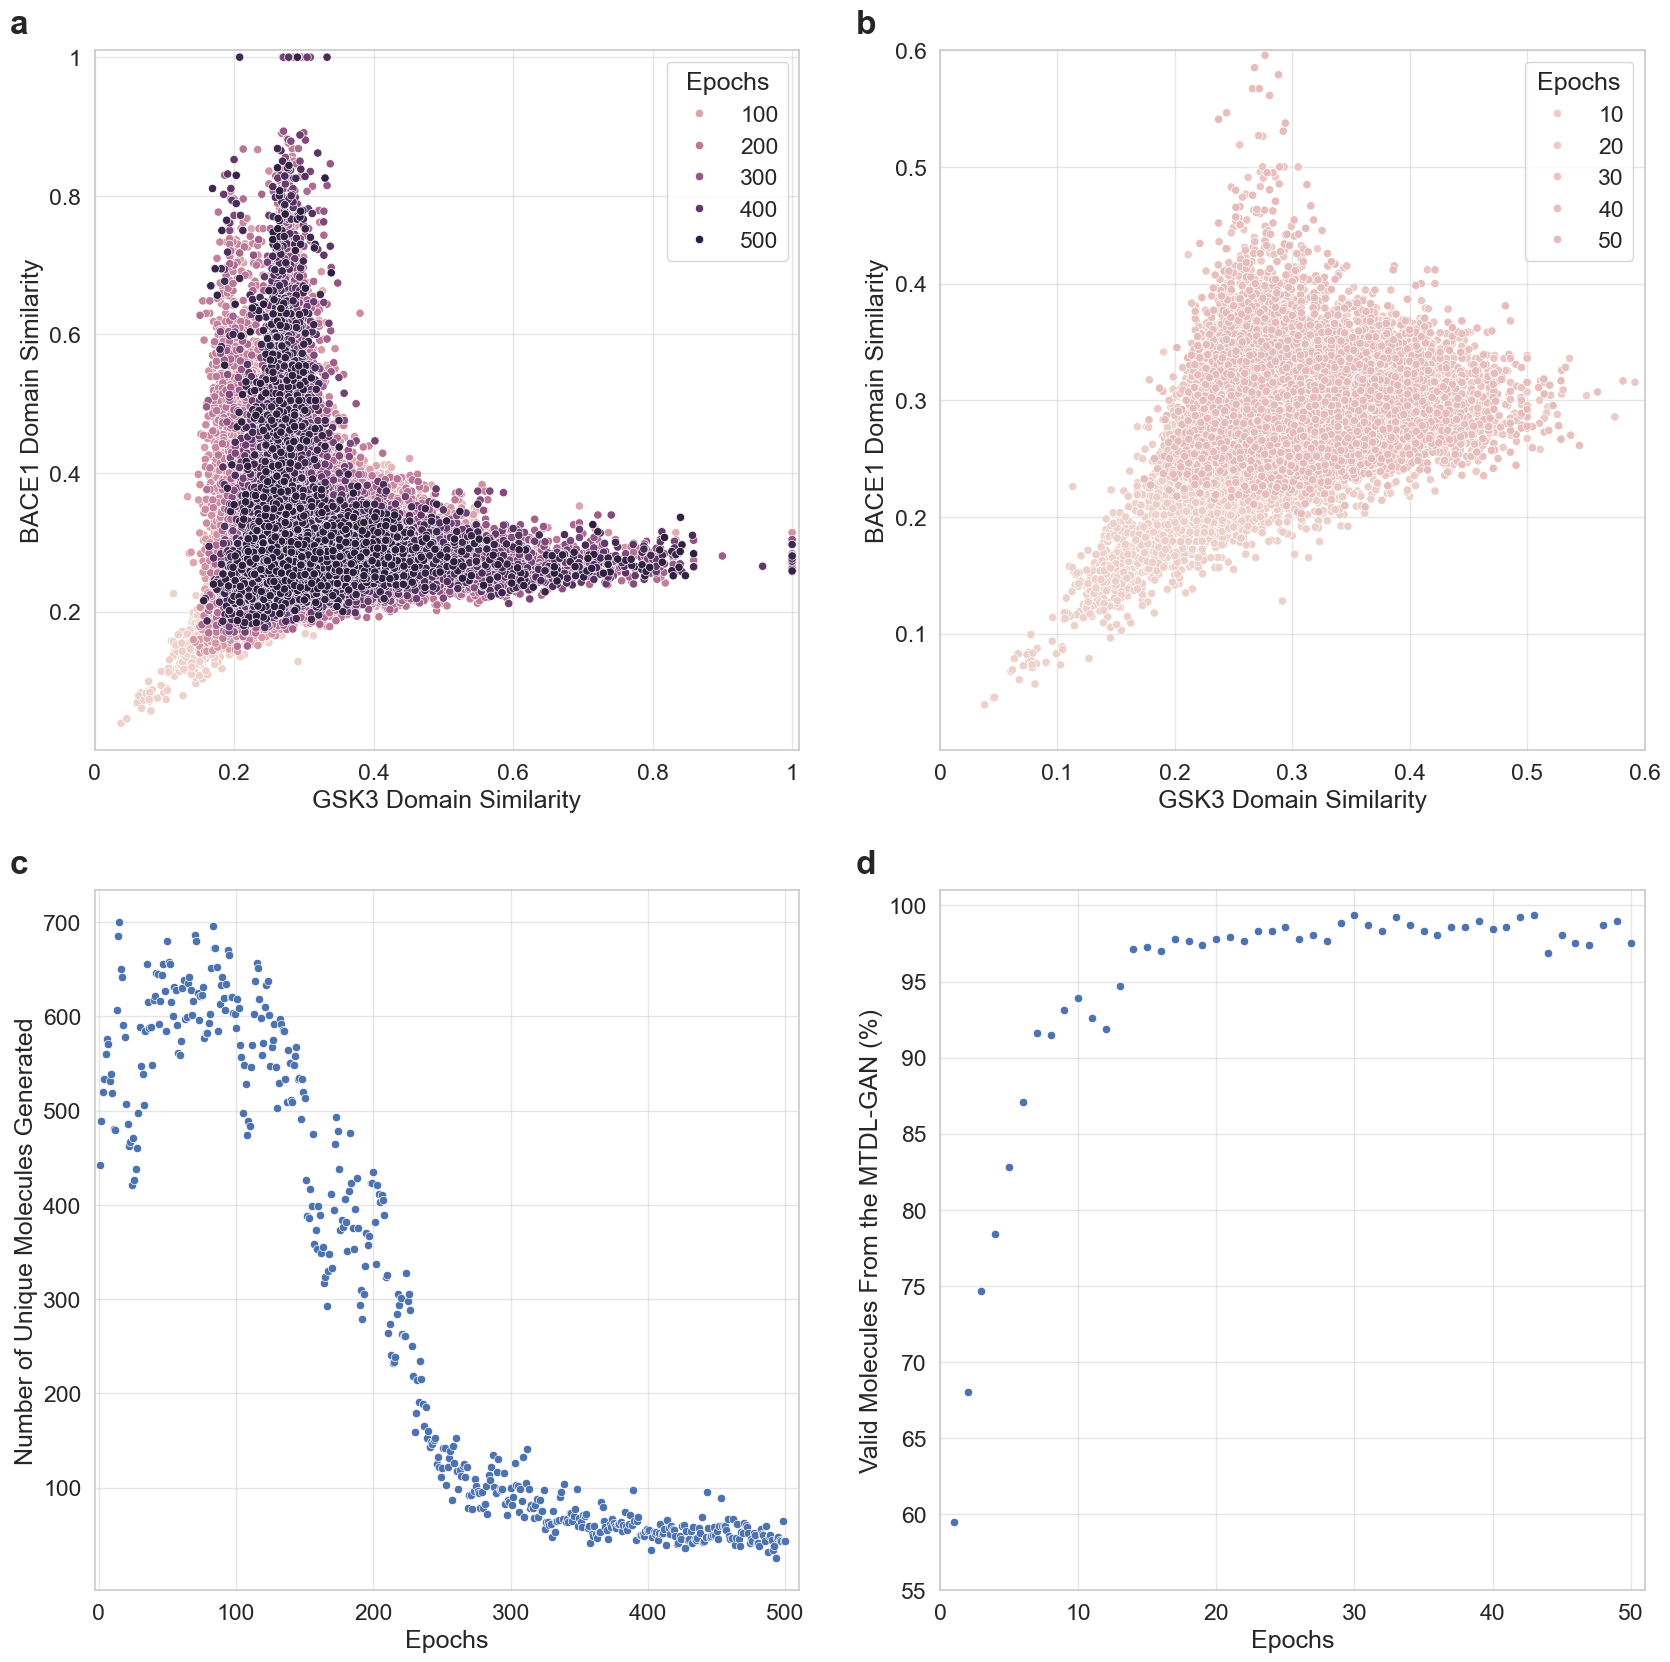

In [9]:
# Integer 0 and 1 from 0.0 and 1.0
from matplotlib.ticker import StrMethodFormatter

sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

import matplotlib as mpl

# normalise colour grading for "epoch (validation_split)"
#cmap = sns.color_palette("Wistia", as_cmap=True)
norm = mpl.colors.Normalize(vmin=df_filter['validation_split'].min(),
                            vmax=df_filter['validation_split'].max())

fig, axes = plt.subplots(figsize = (20, 20), ncols = 2, nrows = 2)

sns.scatterplot(data = df_filter,
               x = 'A_score', y = 'B_score',
                hue = 'validation_split', 
                hue_norm=norm, #palette = cmap,
                ax = axes[0,0])
axes[0,0].set(xlabel = 'GSK3 Domain Similarity',
              ylabel = 'BACE1 Domain Similarity',
              #title = str(df_filter.shape[0]) + ' Generated Molecules in GB MTDL Library'
             )
axes[0,0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axes[0,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1])
axes[0,0].set_xlim(0, 1.01)
axes[0,0].set_ylim(0, 1.01)

axes[0,0].xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
axes[0,0].yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))

axes[0,0].legend(title='Epochs')

sns.scatterplot(data = df_filter[df_filter['validation_split'] <= 50],
               x = 'A_score', y = 'B_score',
                hue = 'validation_split', 
                hue_norm=norm, #palette = cmap,
                ax = axes[0,1])
axes[0,1].set(xlabel = 'GSK3 Domain Similarity',
              ylabel = 'BACE1 Domain Similarity',
              #title = 'Molecular Transformation At Early Epochs'
             )

axes[0,1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
axes[0,1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
axes[0,1].set_xlim(0, 0.6)
axes[0,1].set_ylim(0, 0.6)

axes[0,1].xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
axes[0,1].yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))

axes[0,1].legend(title='Epochs')

# normalise colour grading for "recovery"
norm_recovery = mpl.colors.Normalize(vmin=recovery.min(), vmax=recovery.max())

sns.scatterplot(x = epoch, y = unique, 
                #hue = recovery, hue_norm = norm_recovery,
               palette="Blues", 
                ax = axes[1,0])
axes[1,0].set(xlabel = 'Epochs',
              ylabel = 'Number of Unique Molecules Generated',
              #title = 'Generation of Unique Molecules Decreases Progressively'
             )
axes[1,0].set_xticks([0, 100, 200, 300, 400, 500])
axes[1,0].set_xlim(-3, 510)
axes[1,0].set_yticks([100, 200, 300, 400, 500, 600, 700])

#axes[1,0].legend(title='Unique Molecules (%)')
#handles, labels = axes[1, 0].get_legend_handles_labels()
#new_labels = ['> 50%', '> 60%', '> 70%', '> 80%', '> 90%']
#axes[1, 0].legend(handles=handles, title='Valid Structures (%)', labels=new_labels)

sns.scatterplot(x = epoch[:50], y = recovery[:50],
                #hue = recovery[:50], hue_norm = norm_recovery,
                palette = "Blues",
               ax = axes[1,1])
axes[1,1].set(xlabel = 'Epochs',
              ylabel = 'Valid Molecules From the MTDL-GAN (%)',
              #title = 'Valid Molecules Reach >90% At Early Epochs'
             )
#axes[1,1].set_xticks([100, 200, 300, 400, 500])
axes[1,1].set_yticks([55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
axes[1,1].set_xlim(0, 51)
axes[1,1].set_ylim(55, 101)

#axes[1,1].legend().set_title('Valid Structures (%)')
#handles, labels = axes[1, 1].get_legend_handles_labels()
#axes[1, 1].legend(handles=handles, title='Valid Structures (%)', labels=new_labels)

# Panel letters outside, top-left of each subplot
panel_labels = ['a', 'b', 'c', 'd']
y_offset = 0.005             # vertical gap above each axes
x_shift_frac = 0.12          # move left by 10% of each axes' width

for ax, lab in zip(axes.ravel(), panel_labels):
    bb = ax.get_position()   # figure coords
    x = max(bb.x0 - x_shift_frac * bb.width, 0.0)
    fig.text(x, bb.y1 + y_offset, lab,
             ha='left', va='bottom',
             fontsize=24, fontweight='bold')

# Thin grid lines
for ax in axes.ravel():
    ax.grid(True, linewidth=1, alpha=0.5)
    ax.set_axisbelow(True)
    
plt.savefig('result_fig/GB_MTDL_library_highres.png', dpi=300, bbox_inches='tight')